### Implementation of Mistic 
to our binary description of patient data

### libraries and dirrectories

In [1]:
#set dirrectory
import os
starting_directory = os.getcwd()

#helps when fetching the functions and classes from mistic  
new_dirrectory = 'C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Shared-From-DrK/mistic_breast_cancer_example/mistic_breast_cancer_example'
os.chdir(new_dirrectory)



In [2]:
# Import packages/modules
import matplotlib.pyplot as plt   
plt.rcParams.update({'font.size': 14})

import numpy as np
import pandas as pd

from statistics import mean 
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from seaborn import clustermap, heatmap

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel

# Import functions
from mistic_v1 import greedy_backward_selection, tuneSVM, compute_SV_feature_importance, compute_counterfactuals #, compute_SV_feature_contribution
from mistic_v1 import compute_SV_gradient_rank2, compute_SV_importance_rank, compute_SV_contribution_rank, compute_SV_decision_perturbation

In [3]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from scipy.stats import pearsonr
from mistic_v1 import rank_items

class SV_combined_rank():

    def __init__(self,weight=0.5):
        self.weight = weight

    def compute(self,svc,X,y):
        contribution_rank = compute_SV_contribution_rank(svc,X,y)
        importance_rank = compute_SV_importance_rank(svc,X,y)

        consensus_rank = self.weight*contribution_rank + (1-self.weight)*importance_rank
        rank = rank_items(consensus_rank)
        
        return rank

class svc_score():

    def __init__(self, weight=0.5):
        self.weight = weight

    def score(self,svc,X,y):
        y_pred = svc.predict(X)
        
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        if (tp+fp) > 0:
            precision = tp/(tp+fp)
        else:
            precision = 0
            
        if (tp+fn) > 0:
            recall = tp/(tp+fn)
        else:
            recall = 0
        
        if (precision+recall) > 0:
            f1 = 2*precision*recall/(precision+recall)
        else:
            f1 = 0
            
        auc = roc_auc_score(y, svc.decision_function(X))
        score = self.weight*auc + (1-self.weight)*f1
            
        return pd.DataFrame(data={'f1': f1, 'auc': auc, 'score': score},index=[0])


In [4]:
import shap
from mistic_v1 import compute_SV_integrated_gradient

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
import plotly.express as px
from seaborn import pairplot, load_dataset

In [6]:
import numpy as np
import pickle

In [7]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

### importing our data

In [8]:
#consider changing dirrectory back to a space to save your data that isn't the mistic folder

new_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/SVM_Mistic_Draft_Output_2024-07-16_v1"
os.chdir(new_dirrectory)

#for file outputs
fileName_header = "BinaryCounts_DemoTxNotesLabsAll" #what data did you put in
fileName_common = "_MisticOutput_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_2024-07-16_v1" #date and versioning

saving_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
dataFrameFolderOut = "SVM_Mistic_Draft_Output_2024-07-16_v1"

figDirectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
figFolder = "SVM_Mistic_Draft_Output_2024-07-16_v1"


In [9]:
#file name for inputs
#file full with directory
fileInput_directory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/DFsForSVM_2024-07-10_v1/AL-KnownPts-binnary-Counts-allLabs-tx-notes-Summary-One_2024-07-10_v2.xlsx"


In [10]:
# # Import dataset

dataTable = pd.read_excel(fileInput_directory, header = 0)
dataTable

,DeID,Amyloid Status,Dx,Sex,Age,Survival (in months),5-HIAA Result binary,Anisocytosis Result binary,Macrocytes Result binary,25 Hydroxy Vitamin D Result binary,...,RadTx,RadTx Number,OtherTx,OtherTx Number,ECOG Performance Status binary,Karnofsky Performance Status binary,Clinical Impression of Disease binary,ECOG Performance Status Number of Points,Karnofsky Performance Status Number of Points,Clinical Impression of Disease Number of Points
0,B-02,2,1,0,48,9.466667,0,1,1,0,...,0,0,0,0,1,1,1,5,1,6
1,C-03,2,2,1,59,17.000000,0,0,0,0,...,0,0,0,0,1,1,1,7,4,6
2,E-01,2,1,0,50,71.300000,0,1,1,1,...,0,0,0,0,1,1,1,48,68,50
3,E-02,2,1,0,64,20.466667,0,0,0,0,...,0,0,0,0,1,1,1,2,3,5
4,F-03,2,2,0,61,52.000000,0,0,0,0,...,0,0,0,0,1,1,1,3,2,3
5,G-01,2,2,0,70,104.000000,0,1,1,0,...,0,0,0,0,1,1,1,35,3,24
6,G-02,2,2,1,36,30.000000,0,1,0,1,...,0,0,0,0,1,1,1,7,62,61
7,I-01,2,2,1,55,33.000000,0,1,1,1,...,0,0,0,0,1,1,1,11,28,30
8,I-03,2,1,0,67,10.033333,0,1,1,0,...,0,0,0,0,1,1,1,2,11,3
9,J-02,2,2,1,68,26.000000,0,0,0,0,...,0,0,0,0,1,1,1,8,10,19


In [11]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status']

#columns to use for the y data 
y_column_Classification = 'Amyloid Status'

### scale data

In [12]:
# Scale input X
X = dataTable.copy()
X.drop(columns= x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X) #computes the mean and STD along the features axis

X_train_all = scaler.transform(X) #standardization by centering and scaling
y_train_all = dataTable[y_column_Classification]
X_train_all

array([[-0.74270874, -0.77459667, -1.52139307, ..., -0.35688803,
        -0.63004253, -0.42268684],
       [ 0.8072921 ,  1.29099445, -0.40879537, ..., -0.18558177,
        -0.43823254, -0.42268684],
       [-0.74270874, -0.77459667, -1.31910258, ...,  3.32619642,
         3.65371389,  3.07815472],
       ...,
       [-0.74270874, -0.77459667,  0.90609283, ..., -0.78515366,
        -0.56610587, -0.66138058],
       [ 0.8072921 , -0.77459667, -0.40879537, ...,  0.49964324,
         0.5208174 ,  0.77078188],
       [-2.29270958,  1.29099445,  0.90609283, ..., -0.35688803,
         0.20113409, -0.34312225]])

### creating the classifier

In [13]:
# Number of training sets
NT = 5 

# Data split ratio
val_size = 1/NT

#Feature selection reduction factor
red_factor = 0

In [14]:
# split train set into train and test(val) data / repeat NT times and |get NT number of datsets
CV_sets = []
for i in range(NT):
    X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, 
                                                        stratify = y_train_all, 
                                                        random_state= i, 
                                                        test_size= val_size)
    
    CV_set = {"train": {"X": X_train,"y": y_train}, "test":  {"X": X_test, "y": y_test}} 
    CV_sets.append(CV_set)

In [15]:
C_range = [2**x for x in range(-2,5)] # trade-off between margin and misclassifications.  smaller c, wider margins
gamma_range = [2**x for x in range(-9,1)]

svc = SVC(kernel = 'rbf', class_weight="balanced", probability=False)

tesTune = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range)
tesTune["best_params"]

,c,g,f1,auc,score
0,0.25,0.007812,0.790707,0.768,0.779354


In [16]:
#pickling teh tesTune object
pickle_file = open('tesTune_object_file', 'wb')
pickle.dump(tesTune, pickle_file)

In [17]:
type(tesTune["performance"])

pandas.core.frame.DataFrame

In [18]:
#saving the first test tune set
perf = tesTune["performance"]
tesTune_best_params = tesTune["best_params"]

outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "tesTune perf")
outputToExcel(df_data=tesTune_best_params, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "tesTune best params")

In [19]:
tesTune["best_models"][0].classes_

array([1, 2], dtype=int64)

In [20]:
featRank_A = greedy_backward_selection(svc, X_train_all, CV_sets, compute_SV_importance_rank, svc_score().score, C_range, gamma_range, redF = red_factor)

      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     300      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     299      19.0
      c         g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.76  0.775354     298      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.752  0.771354     297      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.752  0.771354     296      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.744  0.767354     295      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.772929  0.744  0.758465     294      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.744  0.767354     293     

In [21]:
#pickling the featRankA object
pickle_file = open('featRankA_object_file', 'wb')
pickle.dump(featRank_A, pickle_file)

In [22]:
featRank_B = greedy_backward_selection(svc, X_train_all, CV_sets, compute_SV_contribution_rank, svc_score().score, C_range, gamma_range, redF = red_factor)

      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     300      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     299      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     298      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     297      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     296      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     295      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     294      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     293   

In [23]:
#pickling the featRankB object
pickle_file = open('featRankB_object_file', 'wb')
pickle.dump(featRank_B, pickle_file)

In [24]:
featRank_C = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.25).compute, svc_score().score, C_range, gamma_range, redF = red_factor)

      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     300      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     299      19.0
      c         g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.76  0.775354     298      19.0
      c         g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.76  0.775354     297      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.752  0.771354     296      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.776  0.783354     295      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.772929  0.776  0.774465     294      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.772929  0.776  0.774465     293      1

KeyboardInterrupt: 

In [ ]:
#pickling the featRankC object
pickle_file = open('featRankC_object_file', 'wb')
pickle.dump(featRank_C, pickle_file)

In [ ]:
featRank_D = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.5).compute, svc_score().score, C_range, gamma_range, redF = red_factor)

      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     300      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     299      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     298      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     297      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     296      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     295      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     294      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     293   

In [ ]:
#pickling the featRankD object
pickle_file = open('featRankD_object_file', 'wb')
pickle.dump(featRank_D, pickle_file)

In [ ]:
featRank_E = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.75).compute, svc_score().score, C_range, gamma_range, redF = red_factor)

      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     300      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     299      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     298      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     297      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     296      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     295      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     294      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.790707  0.768  0.779354     293   

In [ ]:
#pickling the featRankE object
pickle_file = open('featRankE_object_file', 'wb')
pickle.dump(featRank_E, pickle_file)

### Performance Plots

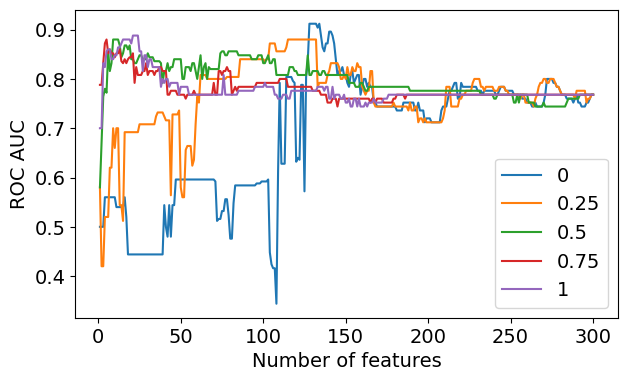

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].auc) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].auc) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].auc) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].auc)
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].auc) 

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()

In [ ]:
#saving figure
figDirectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
figFolder = "SVM_Mistic_Draft_Output_2024-07-11_v1"
figCommon = fileName_common + "fig1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

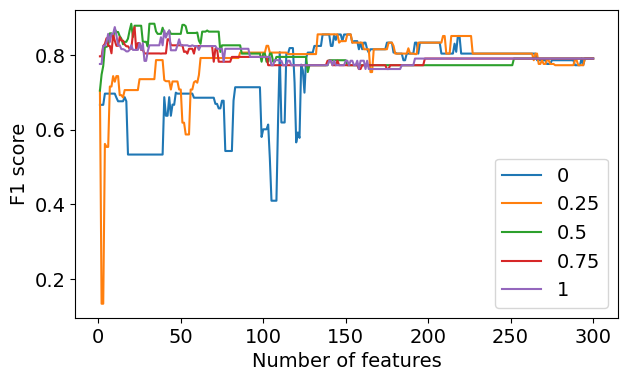

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].f1) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].f1) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].f1) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].f1) 
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].f1) 

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.show()


In [ ]:
figCommon = fileName_common + "fig2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [ ]:
perf = featRank_A["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A perfa")

In [ ]:
perf = featRank_B["performance"]
perf
#saving the performance dataframe
# dataFrameFolderOut = "SVM_Mistic_Draft_Output_2024-07-11_v1"
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B perf")

In [ ]:
perf = featRank_C["performance"]
perf
#saving the performance dataframe
# dataFrameFolderOut = "SVM_Mistic_Draft_Output_2024-07-11_v1"
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C perf")

In [ ]:
perf = featRank_E["performance"]
perf
#saving the performance dataframe
# dataFrameFolderOut = "SVM_Mistic_Draft_Output_2024-07-11_v1"
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E perf")

In [ ]:
perf = featRank_D["performance"]
perf
#saving the performance dataframe
# dataFrameFolderOut = "SVM_Mistic_Draft_Output_2024-07-11_v1"
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D perf")

In [ ]:
X.columns[featRank_D["sorted"].astype(int)]

Index(['RadTx', 'HemeTx Number', 'Plasmacyte Result binary ',
       'Testosterone Result binary ',
       'Erythropoietin Result Number of Points ',
       'Calcium Cation Electrolytes Value Result binary ',
       'Serum Osmolality Result Number of Points ',
       'Calcium Cation Electrolytes Value Result Number of Points ',
       'Pct. Metamyelocyte Result Number of Points ',
       'Pct. Plasmacyte Result binary ',
       ...
       'Serum Electrophoresis Alpha 1 Result Number of Points ',
       'Neutrophil Bands Result binary ', 'GGT Result binary ',
       'GGT Result Number of Points ',
       'Serum Immunologic IgA Result Value Result Number of Points ',
       'Total Cholesterol Result binary ', 'HDL Result(mg/dL) binary ',
       'LDL Result(mg/dL) binary ', 'LDL Result(mg/dL) Number of Points ',
       '25 Hydroxy Vitamin D Result binary '],
      dtype='object', length=300)

In [ ]:
listX = list(X.columns[featRank_D["sorted"].astype(int)])

In [ ]:
df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_D["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D col ranked")

In [ ]:
# import plotly.express as px
# from seaborn import pairplot, load_dataset

### Input the top 3 features from your data set into the following plot for a 3D visualization

In [ ]:
fig = px.scatter_3d(dataTable, x=listX[0], y=listX[1], z=listX[2],
              color= y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

### performance outputs
set the number of features you want to check the performance with

In [ ]:
#setting number of features for performance test
fold = 0
number_feat_perf_test = 25 #describes for testing performance 
numb_features_figures = 5 #number of features to use in plots

In [ ]:
queryText = "nFeats == " + str(number_feat_perf_test)
featRank_A["performance"].query(queryText)

,c,g,f1,auc,score,nFeats,mean_nSV
275,0.25,0.001953,0.533333,0.444,0.488667,25,19.0


In [ ]:
X.columns[featRank_A["sorted"].astype(int)][0:number_feat_perf_test]

Index(['total CO2 Result binary ', 'Urinalysis Spot Sodium Result binary ',
       'Urinalysis Spot Potassium Result binary ', 'OtherTx Number',
       'Sodium Result(mmol/L) binary ', 'Potassium Result(mmol/L) binary ',
       'Creatinine Result(mg/dL) binary ', 'Chloride Result(mmol/L) binary ',
       'OtherTx', 'Calcium Result(mg/dL) binary ',
       'Oxyhemoglobin Result binary ', 'O2 Saturation Result(%) binary ',
       'Methemoglobin Result binary ', 'Erythropoietin Result binary ',
       'Creatinine, Point of care Result binary ',
       'Carboxyhemoglobin Result binary ', 'PaO2 Result binary ',
       'T4 Result (ug/mL) binary ', 'Tumor Marker AFP Test Un Result binary ',
       'ABG pH Result binary ', 'ABG Base Excess Result binary ',
       '5-HIAA Result Number of Points ',
       'ABG Base Excess Result Number of Points ',
       'Carboxyhemoglobin Result Number of Points ', '5-HIAA Result binary '],
      dtype='object')

In [ ]:
df_columnNames_rankedA = pd.DataFrame(X.columns[featRank_A["sorted"].astype(int)])
#saving the column ranking
outputToExcel(df_data=df_columnNames_rankedA, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A col ranked")

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN bef

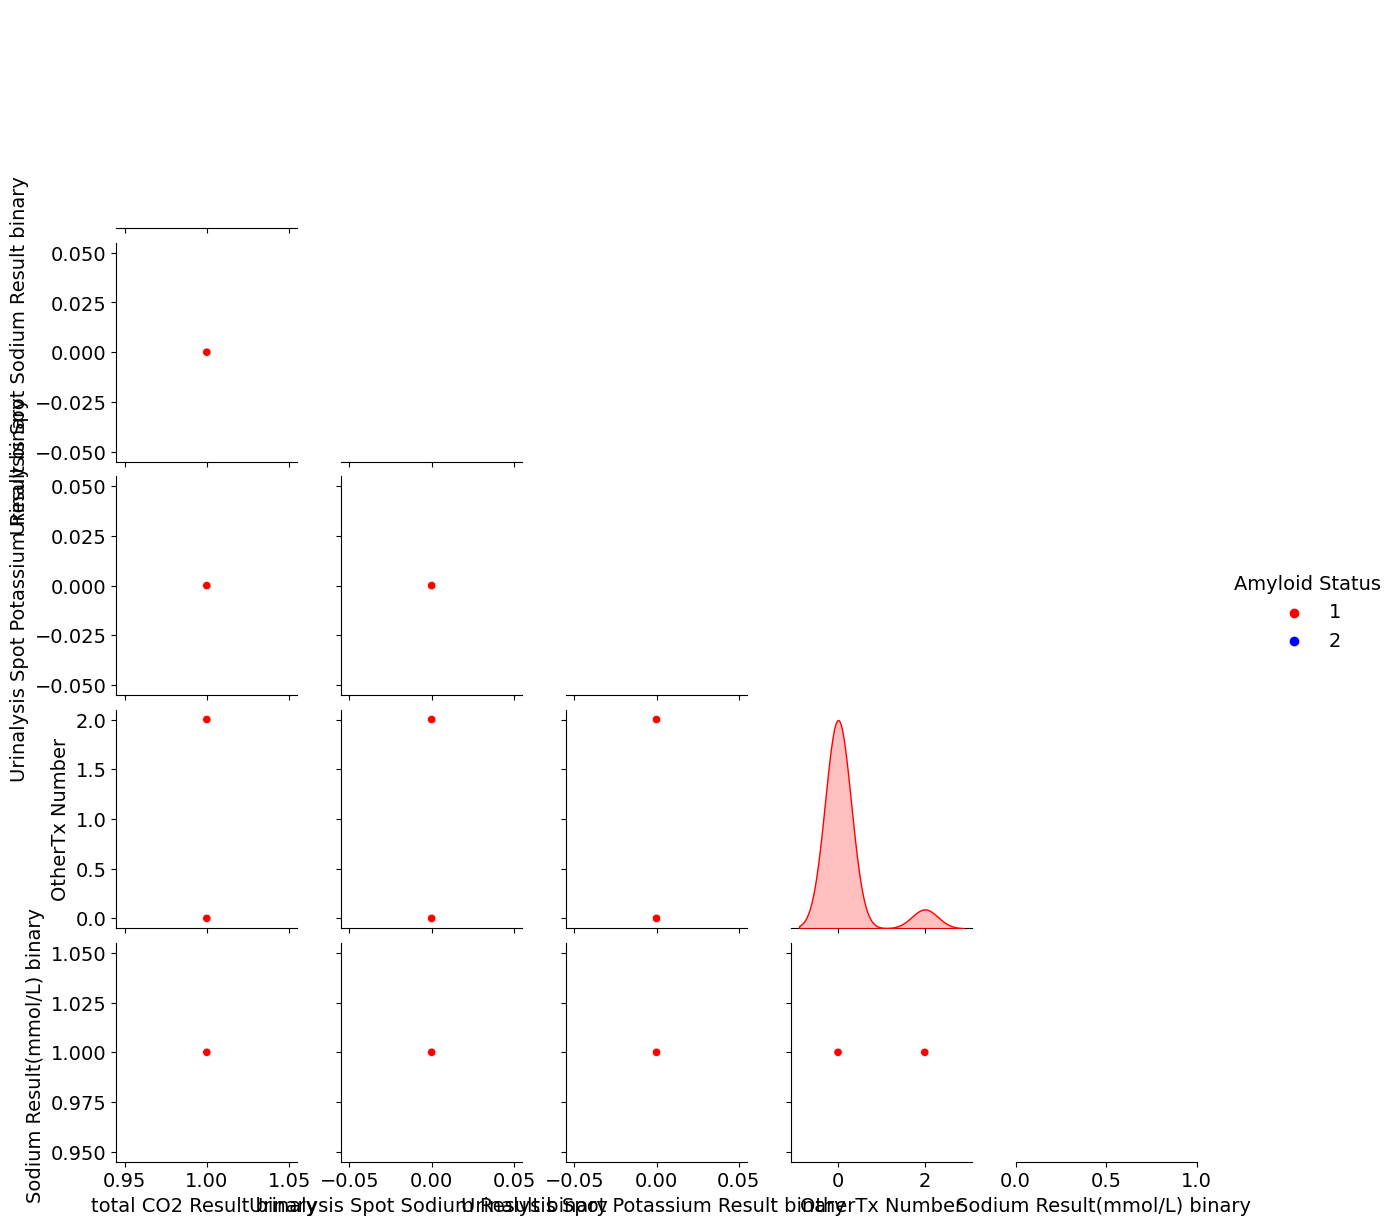

In [ ]:
palette = {np.int64(1) :'red', np.int64(2): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_A["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A compare features")

figCommon = fileName_common + "featRankA"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [ ]:
# pairplot(dataTable[['RadTx', 'HemeTx Number', 'Plasmacyte Result binary ']],hue=y_column_Classification, corner=True, palette={"M":"red","B":"blue"})

In [ ]:
# featRank_B["performance"].query("nFeats == 3")
queryText = "nFeats == " + str(number_feat_perf_test)
featRank_B["performance"].query(queryText)

,c,g,f1,auc,score,nFeats,mean_nSV
275,4.0,0.003906,0.832168,0.856,0.844084,25,15.4


In [ ]:
X.columns[featRank_B["sorted"].astype(int)][0:number_feat_perf_test]

Index(['Calcium Cation Electrolytes Value Result Number of Points ',
       'Urine Glucose Result(mg/dL) binary ',
       'Metamyelocyte Result Number of Points ',
       'Pct. Metamyelocyte Result binary ', 'PSA Result Number of Points ',
       'B12 Result (pg/mL) binary ',
       'Lambda Free Light Chains Result (mg/L) binary ',
       'Urinalysis M Spike Result Number of Points ',
       'Urinalysis Spot Creatinine Result Number of Points ',
       'Urinalysis Overnight Creatinine Result Number of Points ',
       'Erythrocyte SR Result Number of Points ', 'T4 Result (ug/mL) binary ',
       'Clinical Impression of Disease Number of Points ',
       'Arterial Lactic Acid Result binary ', 'Metamyelocyte Result binary ',
       'RDW Result binary ',
       'Serum Immunologic IgA Result Value Result binary ',
       'Pct. Myelocyte Result Number of Points ',
       'Beta-2-Microglobulin Result binary ',
       'Arterial Lactic Acid Result Number of Points ',
       '25 Hydroxy Vitamin

In [ ]:
df_columnNames_rankedB = pd.DataFrame(X.columns[featRank_B["sorted"].astype(int)])
#saving the column ranking
outputToExcel(df_data=df_columnNames_rankedB, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B col ranked")

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN bef

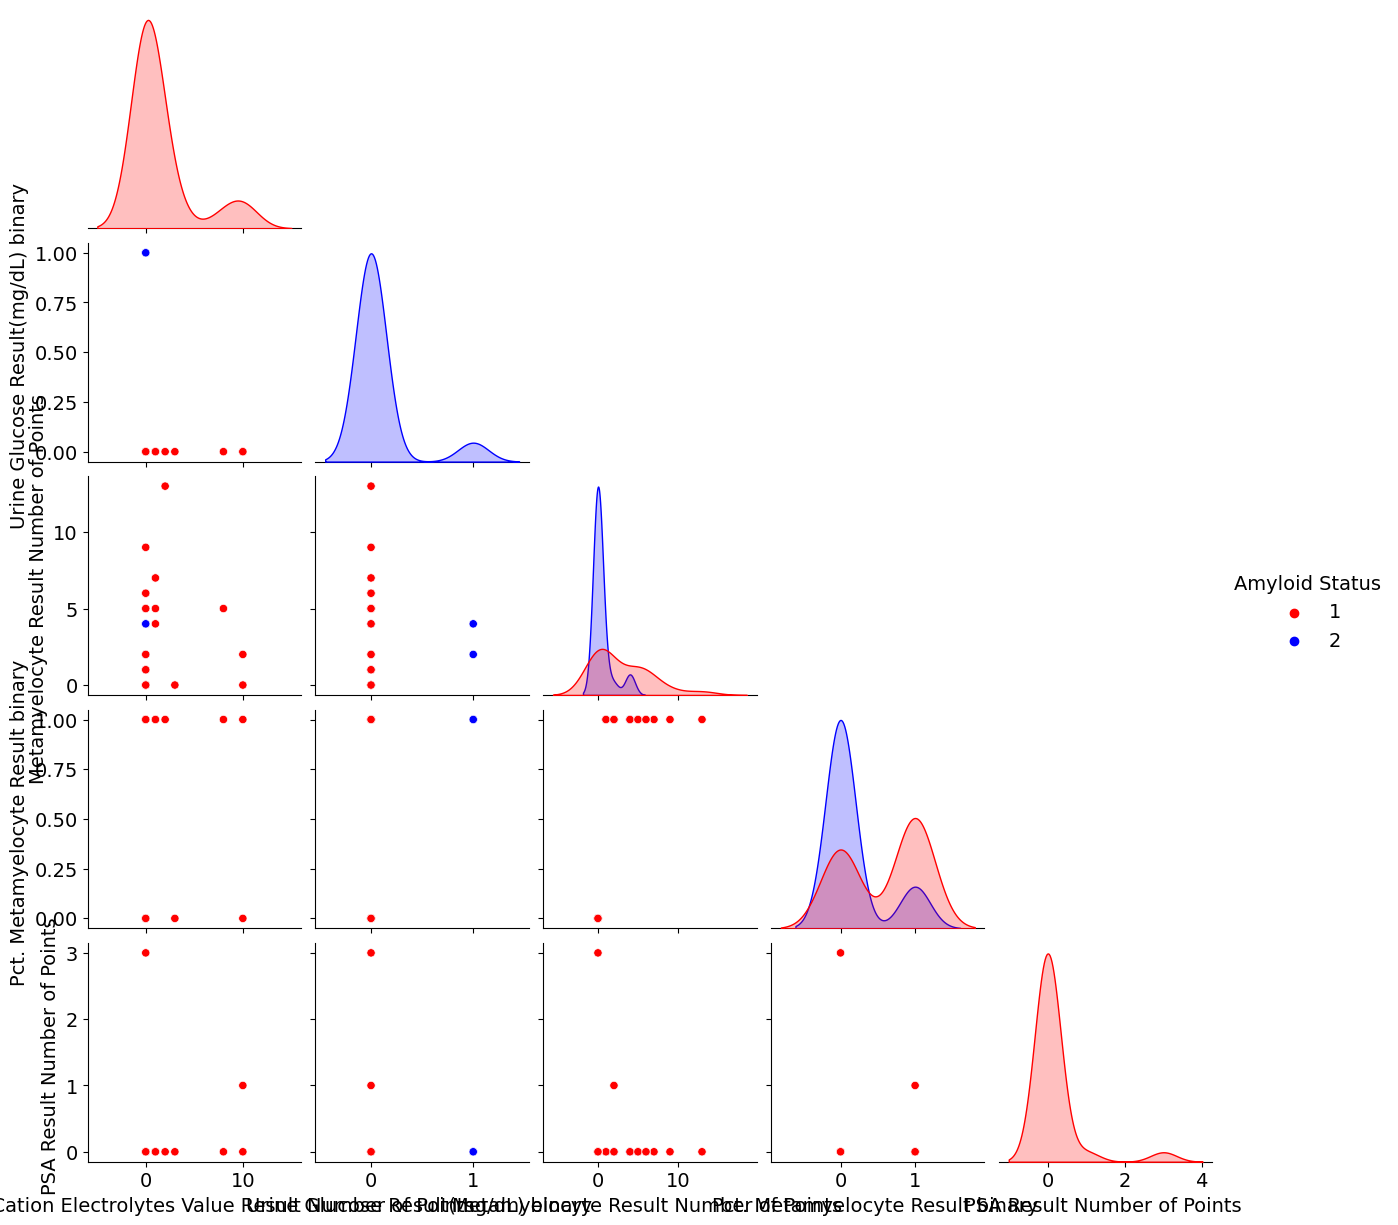

In [ ]:
palette = {np.int64(1) :'red', np.int64(2): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_B["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A 5 features", loc = 'center')

figCommon = fileName_common + "featRankB_5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [ ]:
# pairplot(dataTable[['Radius worst', 'Symmetry SE', 'Texture mean','Diagnosis']],hue="Diagnosis", corner=True, palette={"M":"red","B":"blue"})

In [ ]:
queryText = "nFeats == " + str(number_feat_perf_test)
featRank_D["performance"].query(queryText)

,c,g,f1,auc,score,nFeats,mean_nSV
275,1.0,0.007812,0.878788,0.848,0.863394,25,18.0


In [ ]:
# featRank_D["performance"].query("nFeats == 5")

In [ ]:
X.columns[featRank_D["sorted"].astype(int)][0:number_feat_perf_test]

Index(['RadTx', 'HemeTx Number', 'Plasmacyte Result binary ',
       'Testosterone Result binary ',
       'Erythropoietin Result Number of Points ',
       'Calcium Cation Electrolytes Value Result binary ',
       'Serum Osmolality Result Number of Points ',
       'Calcium Cation Electrolytes Value Result Number of Points ',
       'Pct. Metamyelocyte Result Number of Points ',
       'Pct. Plasmacyte Result binary ', 'PSA Result Number of Points ',
       'Arterial Lactic Acid Result Number of Points ',
       'T4 Result (ug/mL) Number of Points ', 'HemeTx',
       'Arterial Lactic Acid Result binary ',
       'Metamyelocyte Result Number of Points ',
       'Urine Glucose Result(mg/dL) binary ',
       'Serum Osmolality Result binary ', 'Pct. Metamyelocyte Result binary ',
       'ImmunoTx Number', 'T4 Result (ug/mL) binary ',
       'Urine Glucose Result(mg/dL) Number of Points ',
       'Urinalysis Overnight Creatinine Result binary ',
       'Metamyelocyte Result binary ', 'Amy

In [ ]:
df_columnNames_rankedD = pd.DataFrame(X.columns[featRank_D["sorted"].astype(int)])
#saving the column ranking
outputToExcel(df_data=df_columnNames_rankedD, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D col ranked")

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN bef

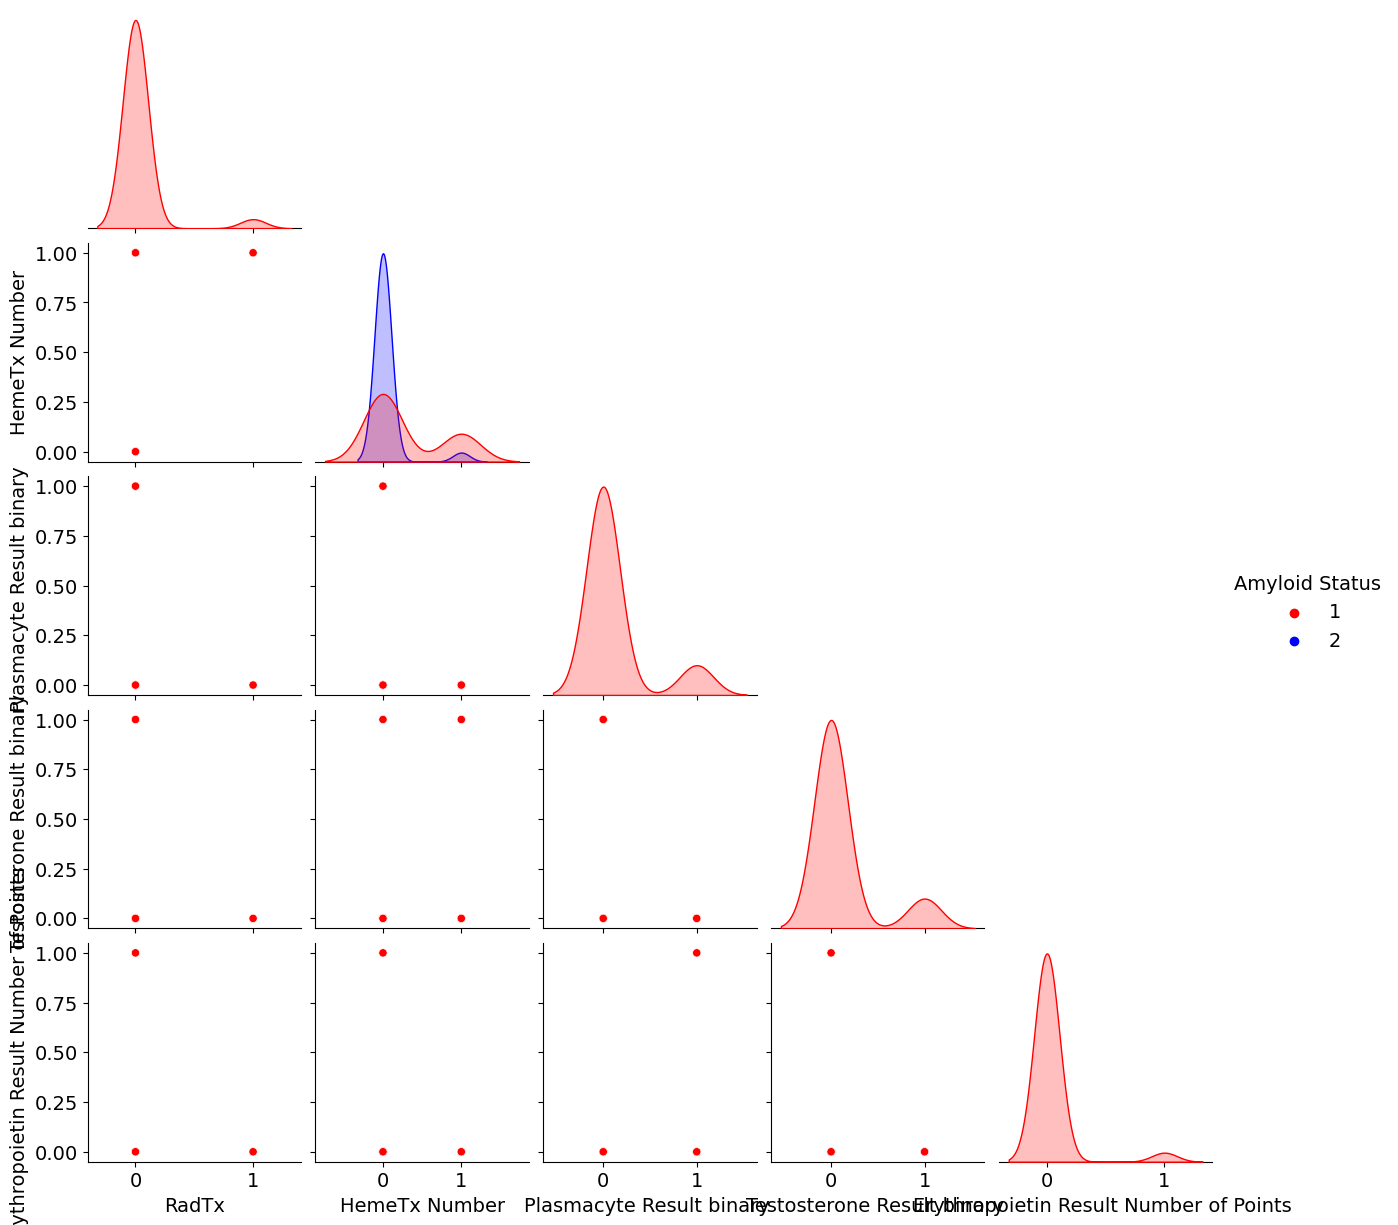

In [ ]:
palette = {np.int64(1) :'red', np.int64(2): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_D["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A 5 features", loc = 'center')

figCommon = fileName_common + "featRankD_5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [ ]:
# pairplot(dataTable[['Area worst', 'Concave Points worst', 'Texture worst','Diagnosis']],hue="Diagnosis", corner=True, palette={"M":"red","B":"blue"})

In [ ]:
# tesTune2 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featRank_D["sorted"][0:10].astype(int))
# tesTune2["best_params"]

   c         g        f1    auc     score
0  1  0.007812  0.878788  0.848  0.863394


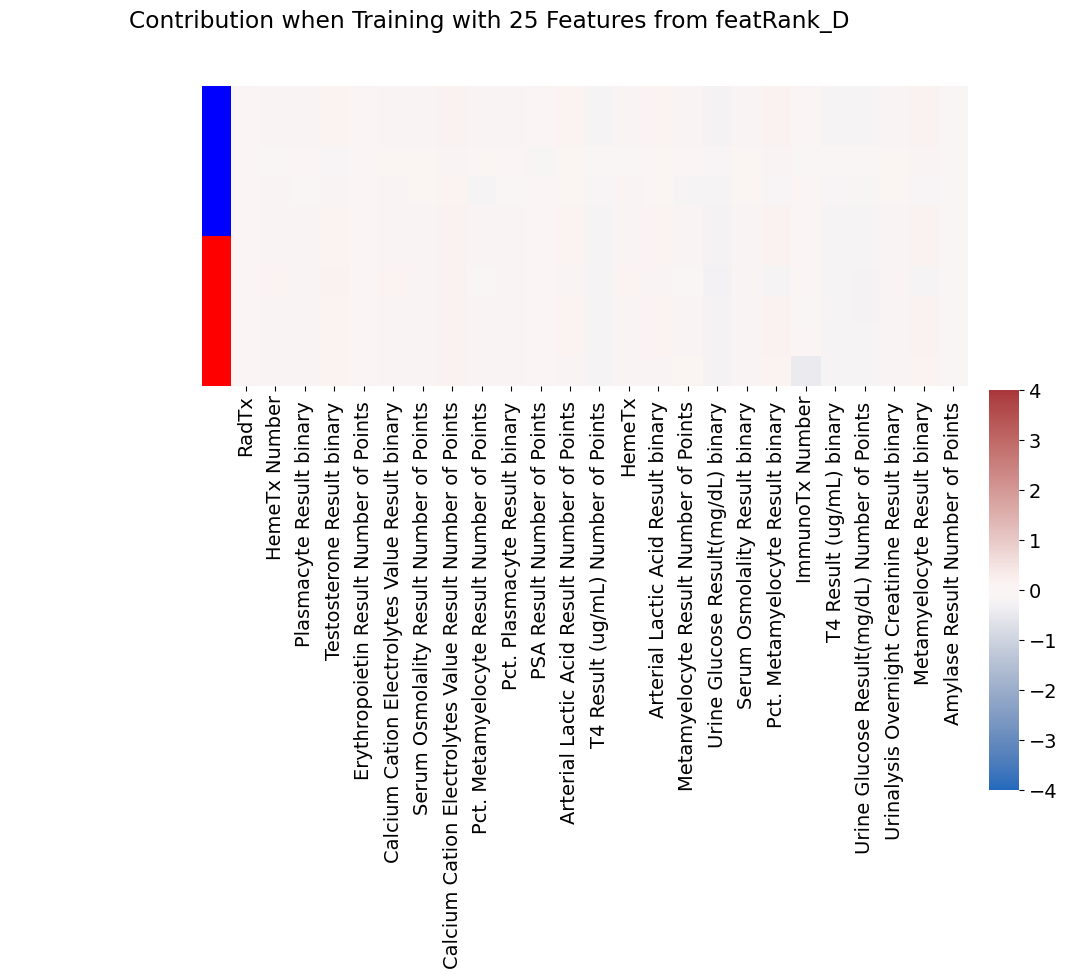

In [ ]:
# import shap
# from mistic_v1 import compute_SV_integrated_gradient

# fold = 0
# number_feat_perf_test = 25
tesTune2 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featRank_D["sorted"][0:number_feat_perf_test].astype(int))
print(tesTune2["best_params"])

feat_contribution = compute_SV_decision_perturbation(tesTune2["best_models"][fold],CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:number_feat_perf_test].astype(int)])
FItable = pd.DataFrame(feat_contribution, index=CV_sets[fold]["test"]["y"],columns=X.columns[featRank_D["sorted"][0:number_feat_perf_test].astype(int)])

FItable.reset_index(drop=True, inplace=True)
fig = clustermap(FItable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
           yticklabels=False,
           cmap="vlag", vmin=-4, vmax=4,
           #row_linkage=hcRow, col_linkage=hcCol, 
           row_cluster=False,col_cluster=False,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
plt.suptitle("Contribution when Training with "+  str(number_feat_perf_test)+ " Features from featRank_D")

figCommon = fileName_common + "fig3"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

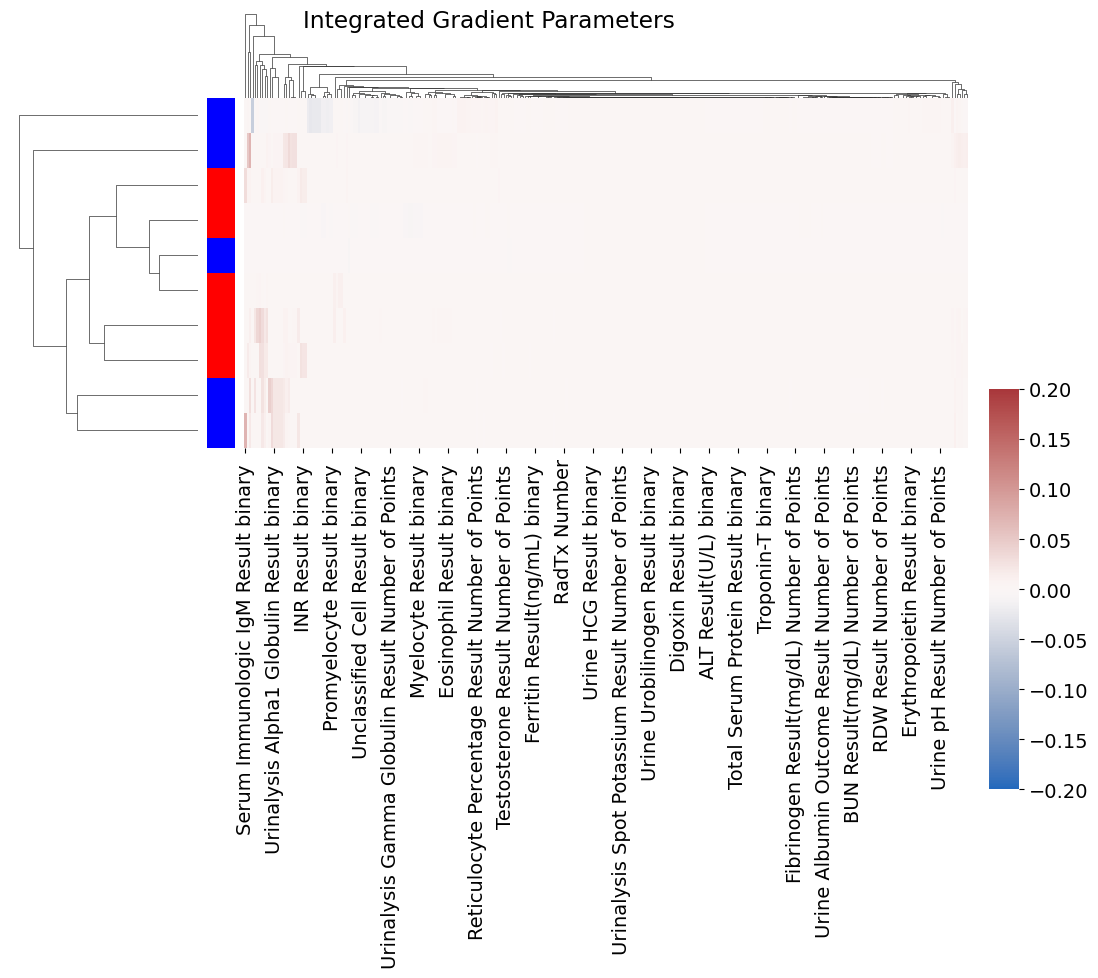

In [ ]:
IG = compute_SV_integrated_gradient(tesTune["best_models"][0], CV_sets[0]["test"]["X"])

IGtable = pd.DataFrame(IG,columns=X.columns)

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-0.2, vmax=0.2,
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values])
plt.suptitle("Integrated Gradient Parameters")
plt.show()

figCommon = fileName_common + "fig4"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



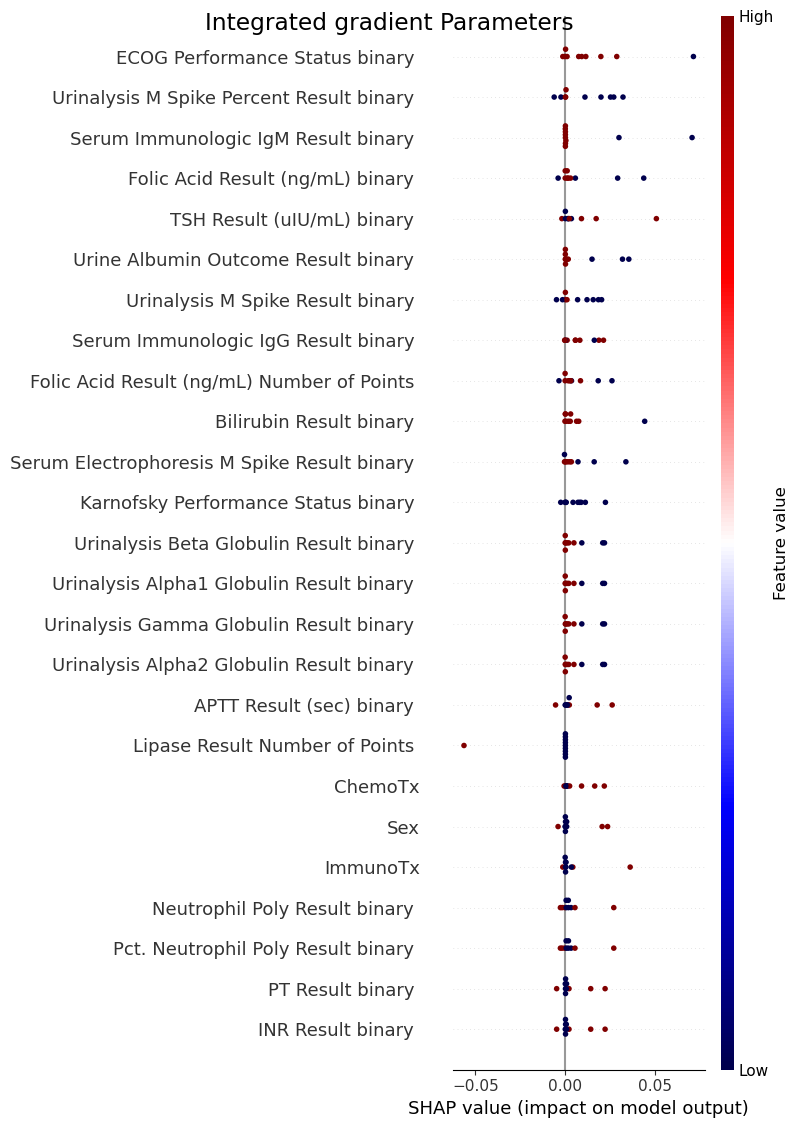

In [ ]:
# number_feat_perf_test = 25
fig = shap.summary_plot(IG,  CV_sets[fold]["test"]["X"], max_display=number_feat_perf_test , 
                  feature_names=X.columns,cmap="seismic", show = False)
plt.suptitle("Integrated gradient Parameters")
figCommon = fileName_common + "fig5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

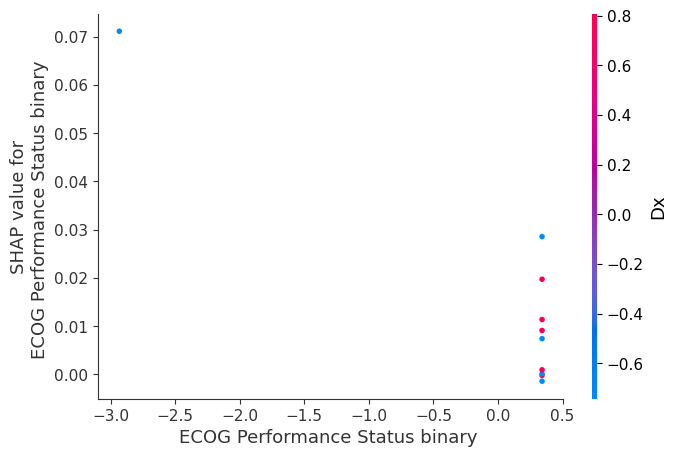

In [ ]:
Xcv = pd.DataFrame(CV_sets[fold]["test"]["X"], 
                     index=CV_sets[fold]["test"]["y"],
                     columns=X.columns)

shap.dependence_plot('ECOG Performance Status binary ', IG, Xcv, show= False)
figCommon = fileName_common + "fig6"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')


In [ ]:
np.argsort(CV_sets[fold]["test"]["y"].values)

array([0, 1, 3, 5, 9, 2, 4, 6, 7, 8], dtype=int64)

In [ ]:
topFeaturesNumber = number_feat_perf_test

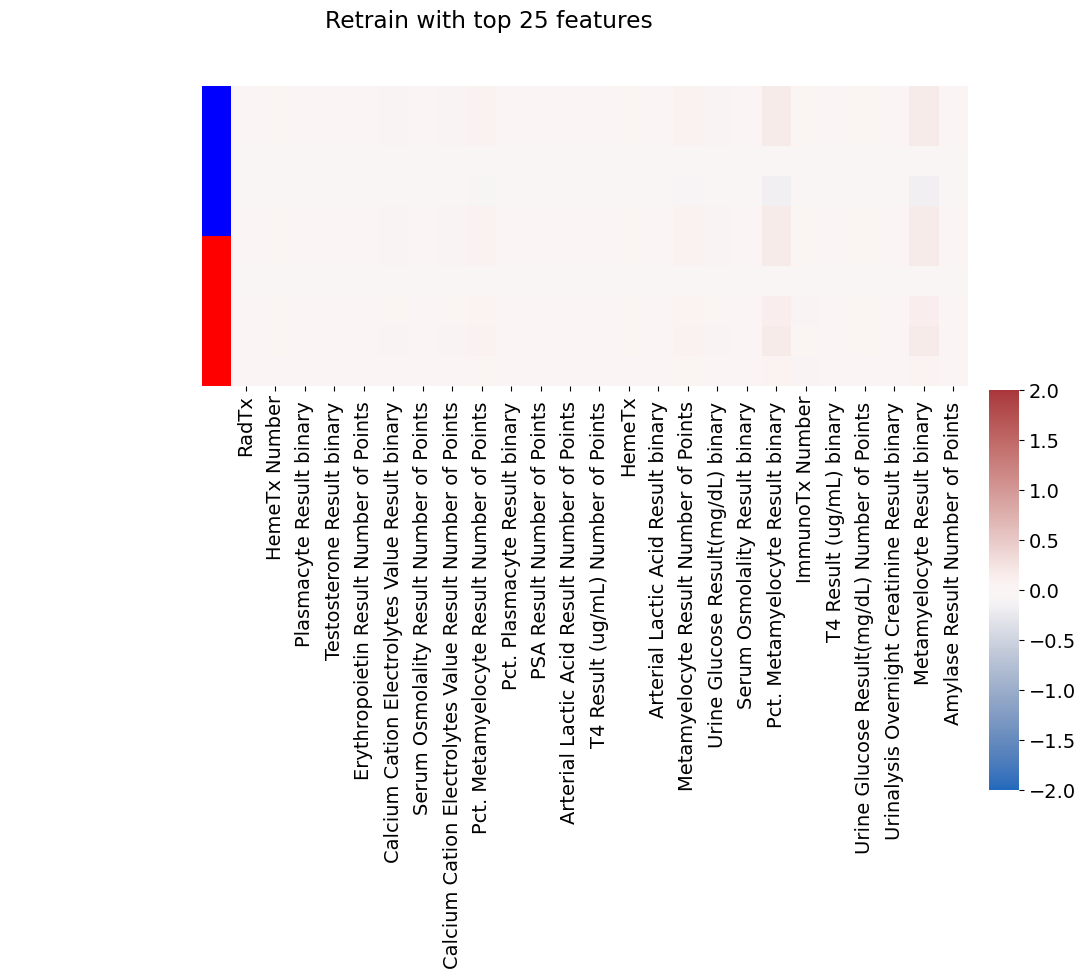

In [ ]:
Xtop3 = pd.DataFrame(CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber ].astype(int)], 
                     index=CV_sets[fold]["test"]["y"],
                     columns=X.columns[featRank_D["sorted"][0:topFeaturesNumber ].astype(int)])
IG = compute_SV_integrated_gradient(tesTune2["best_models"][fold],
                                   CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber].astype(int)])

IGtable = pd.DataFrame(IG, index=CV_sets[fold]["test"]["y"],columns=X.columns[featRank_D["sorted"][0:topFeaturesNumber].astype(int)])

IGtable.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=-2, vmax=2,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[fold]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])

plt.suptitle("Retrain with top "+ str(topFeaturesNumber) +' features')
plt.show()

figCommon = fileName_common + "fig7"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



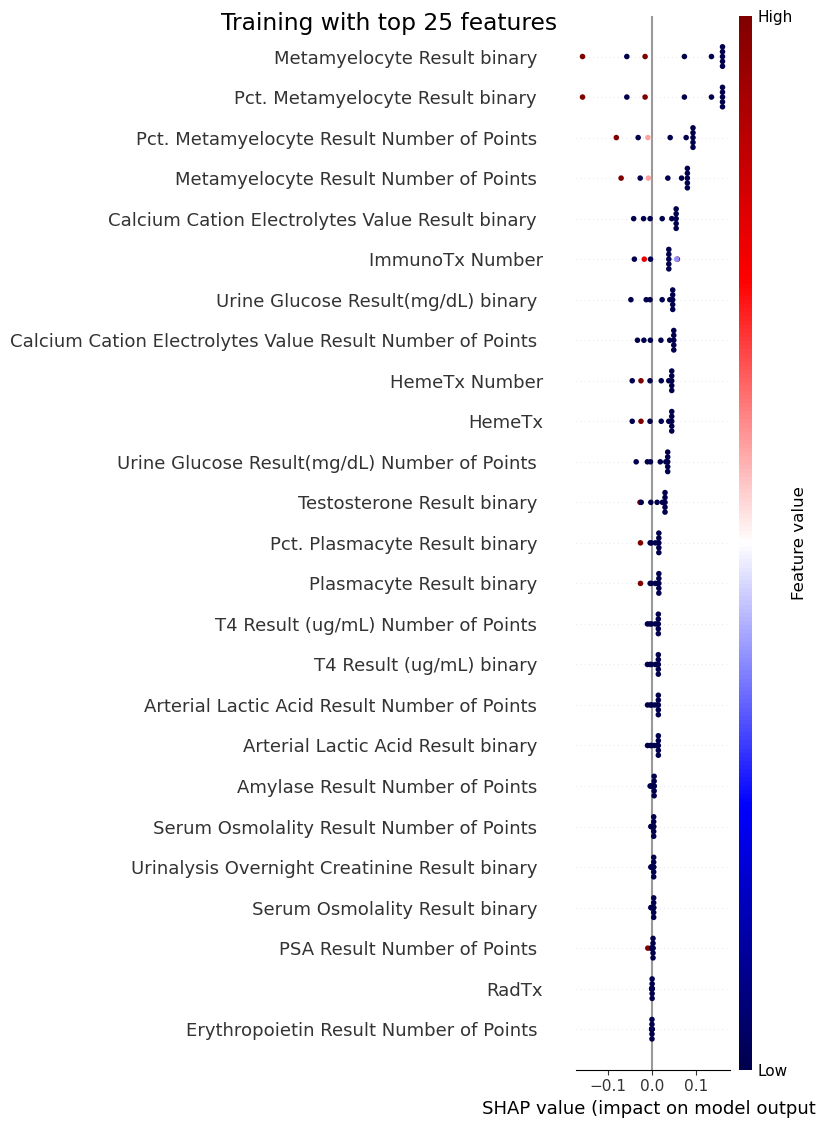

In [ ]:
fig = shap.summary_plot(IG,  CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber ].astype(int)], max_display=topFeaturesNumber , 
                  feature_names=X.columns[featRank_D["sorted"][0:topFeaturesNumber ].astype(int)],cmap="seismic", show = False)
plt.suptitle("Training with top "+ str(topFeaturesNumber) +' features')
# plt.show()

figCommon = fileName_common + "fig8"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

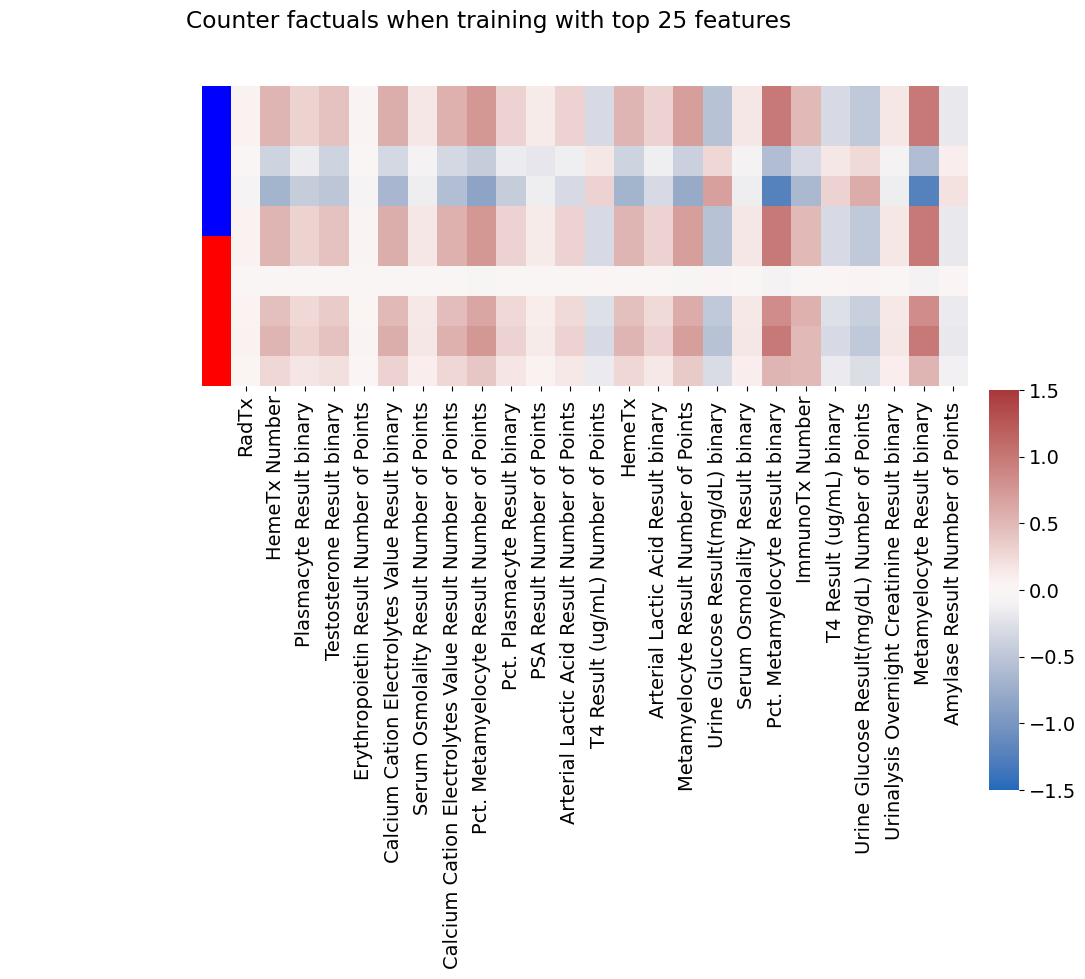

In [ ]:
counterfactuals = compute_counterfactuals(tesTune2["best_models"][fold], 
                                          CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber].astype(int)])
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets[fold]["test"]["y"],columns=X.columns[featRank_D["sorted"][0:topFeaturesNumber].astype(int)])

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=-1.5, vmax=1.5,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[fold]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
plt.suptitle("Counter factuals when training with top "+ str(topFeaturesNumber) +' features')
# plt.show()

figCommon = fileName_common + "fig9"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')